<a href="https://colab.research.google.com/github/thayckowisk/LIA/blob/main/Projeto_03_Predi%C3%A7%C3%A3o_de_Doen%C3%A7as_Cardiacas_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<hr style="height:10px">

<div class='container2'>
	<div style='padding: 0 7em 2em 12em;'>
	<h1>Laboratório de Inovação e Automação 1 (LIA 1)</h1>
	<div style="font-size:12pt;float:left;"> 2025/2 | 24M34 | Sala 200 CAE</div><br><br>
    <div style="font-size:12pt;float:left;"><b>Projetos de Inteligência Artificial - Análise Exploratória de Dados </b></div>
	</div>
</div>


 <hr style="height:5px">
    
<h2>Análise de Dados e Predição de Doenças Cardíacas</h2>

Notebook desenvolvido por: <a href="https://www.linkedin.com/in/thayckowisk-campos">Aluno Thayckowisk Campos</a>

 <hr style="height:2px">

Carregamento de Bibliotecas

In [ ]:
# Importa as bibliotecas necessárias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização para os gráficos (opcional)
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

# Carrega o dataset, reconhecendo '?' como valores ausentes
df_dataset = pd.read_csv('heart_disease_uci.csv', na_values=['?'])

2. Análise Exploratória de Dados

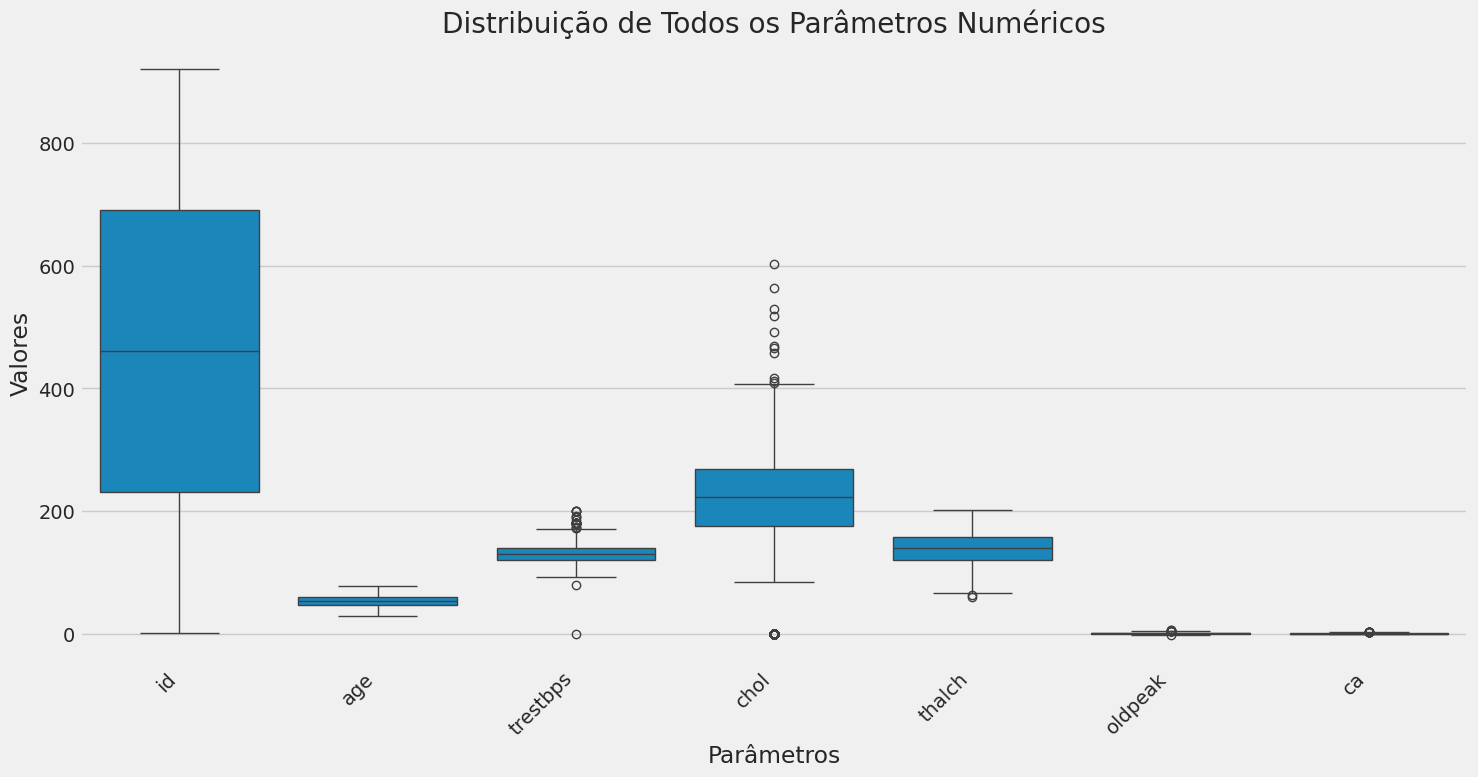

In [ ]:
# --- FUNÇÃO PARA PLOTAR BOXPLOT MÚLTIPLO (CÓDIGO NOVO) ---
def plot_multi_boxplot(df):
    """Plota um boxplot para todos os parâmetros numéricos em um único gráfico."""
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

    # Remove a coluna 'num' para não influenciar no boxplot das features
    numerical_cols.remove('num')

    # Transforma os dados para o formato longo para plotar
    df_melted = df.melt(value_vars=numerical_cols, var_name='Parâmetros', value_name='Valores')

    plt.figure(figsize=(15, 8))
    sns.boxplot(x='Parâmetros', y='Valores', data=df_melted)
    plt.title('Distribuição de Todos os Parâmetros Numéricos')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Exemplo de uso da nova função
plot_multi_boxplot(df_dataset)

In [ ]:
# --- FUNÇÕES DE VISUALIZAÇÃO E LIMPEZA ---
def plot_multi_boxplot(df):
    """Plota um boxplot para todos os parâmetros numéricos em um único gráfico."""
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

    if 'num' in numerical_cols:
        numerical_cols.remove('num')

    df_melted = df.melt(value_vars=numerical_cols, var_name='Parâmetros', value_name='Valores')

    plt.figure(figsize=(15, 8))
    sns.boxplot(x='Parâmetros', y='Valores', data=df_melted)
    plt.title('Distribuição de Todos os Parâmetros Numéricos')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_histogram(df, column_name):
    """Plota um histograma para a coluna especificada."""
    plt.figure(figsize=(8, 6))
    sns.histplot(df[column_name], kde=True)
    plt.title(f'Distribuição da Coluna: {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequência')
    plt.show()

def remove_outliers(df, columns):
    """Remove outliers de múltiplas colunas de um DataFrame usando o método IQR."""
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df




Primeiras 5 linhas do dataset preparado:
   age  trestbps   chol  thalch  oldpeak   ca  sex_Male  cp_atypical angina  \
0   63     145.0  233.0   150.0      2.3  0.0      True               False   
1   67     160.0  286.0   108.0      1.5  3.0      True               False   
2   67     120.0  229.0   129.0      2.6  2.0      True               False   
3   37     130.0  250.0   187.0      3.5  0.0      True               False   
4   41     130.0  204.0   172.0      1.4  0.0     False                True   

   cp_non-anginal  cp_typical angina  fbs_True  restecg_normal  \
0           False               True      True           False   
1           False              False     False           False   
2           False              False     False           False   
3            True              False     False            True   
4           False              False     False           False   

   restecg_st-t abnormality  exang_True  slope_flat  slope_upsloping  \
0             

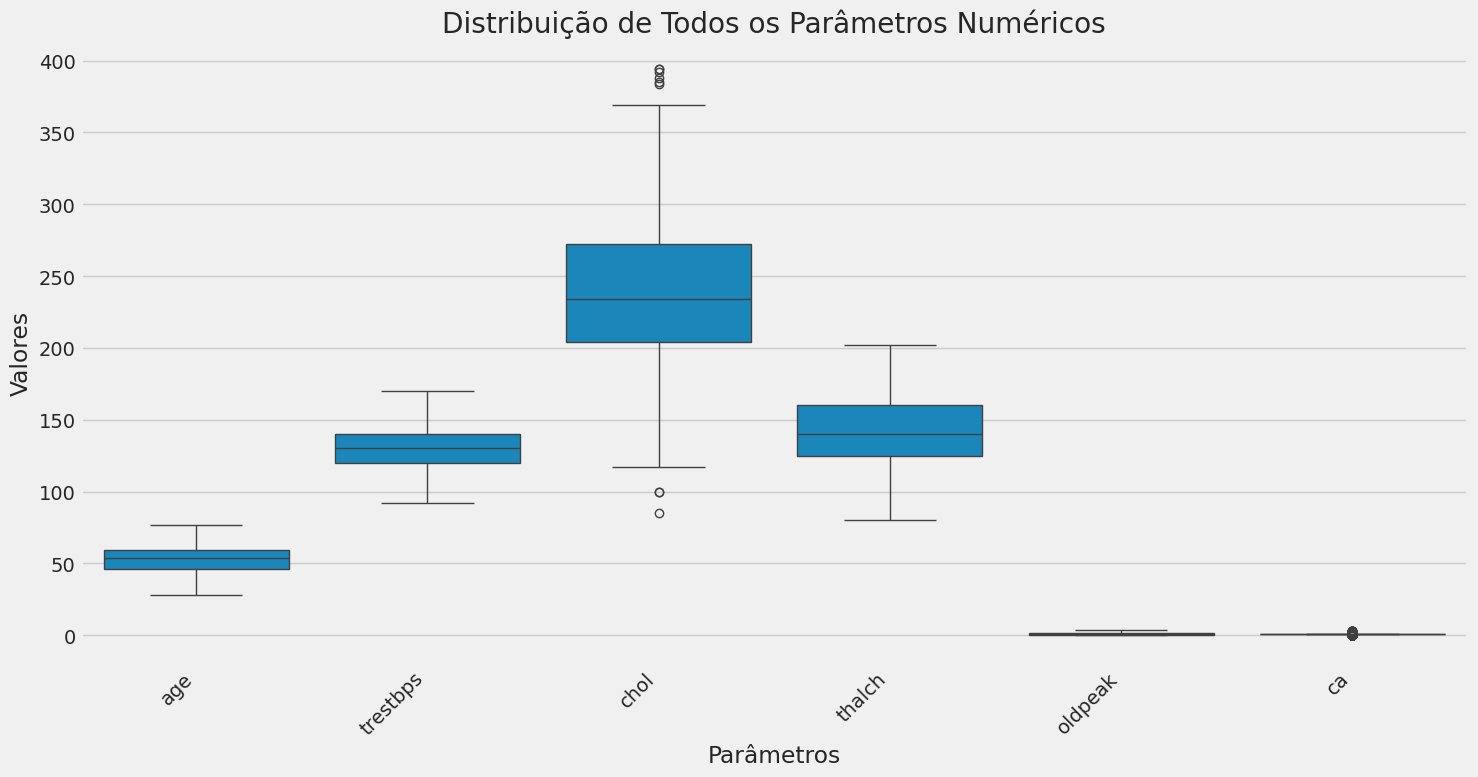

In [ ]:
# --- LIMPEZA E PREPARAÇÃO DOS DADOS ---
# Remove as colunas que não são úteis
df_dataset.drop(['id', 'dataset'], axis=1, inplace=True, errors='ignore')

# Preenche valores nulos nas colunas numéricas com a média
df_dataset.fillna(df_dataset.mean(numeric_only=True), inplace=True)

# Converte a variável alvo 'num' para um problema de classificação binária (0 ou 1)
df_dataset['num'] = df_dataset['num'].apply(lambda x: 1 if x > 0 else 0)

# Lista de colunas numéricas para remover outliers
numerical_cols_to_clean = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
df_dataset = remove_outliers(df_dataset, numerical_cols_to_clean)

# Converte as colunas categóricas restantes em variáveis numéricas (one-hot encoding)
df_dataset = pd.get_dummies(df_dataset, drop_first=True)

# Separa os dados em features (X) e a variável alvo (y)
X = df_dataset.drop('num', axis=1)
y = df_dataset['num']

# Divide os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Exibe informações sobre o dataset após a limpeza
print("\nPrimeiras 5 linhas do dataset preparado:")
print(X.head())
print("\nValores nulos nas Features (X) antes do modelo:")
print(X.isnull().sum().sum())

# Exemplo de uso das funções de plotagem
print("\nVisualizações da distribuição dos dados:")
plot_multi_boxplot(df_dataset)

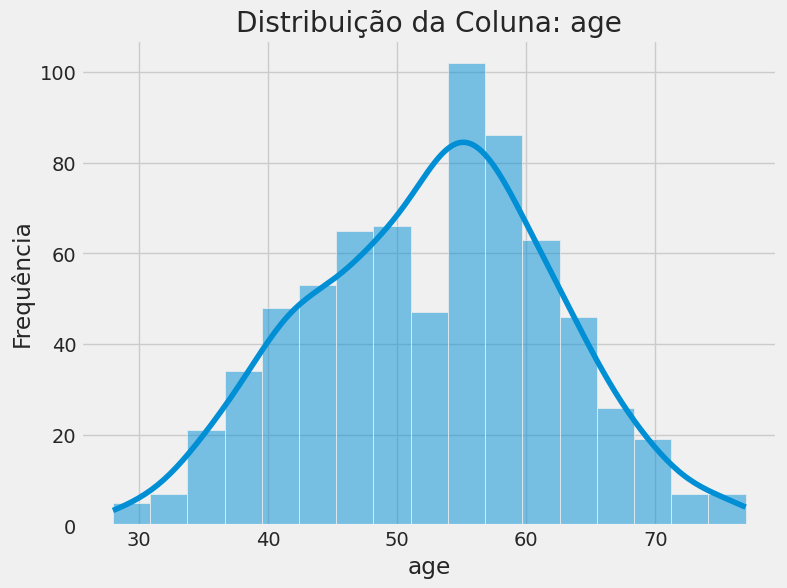

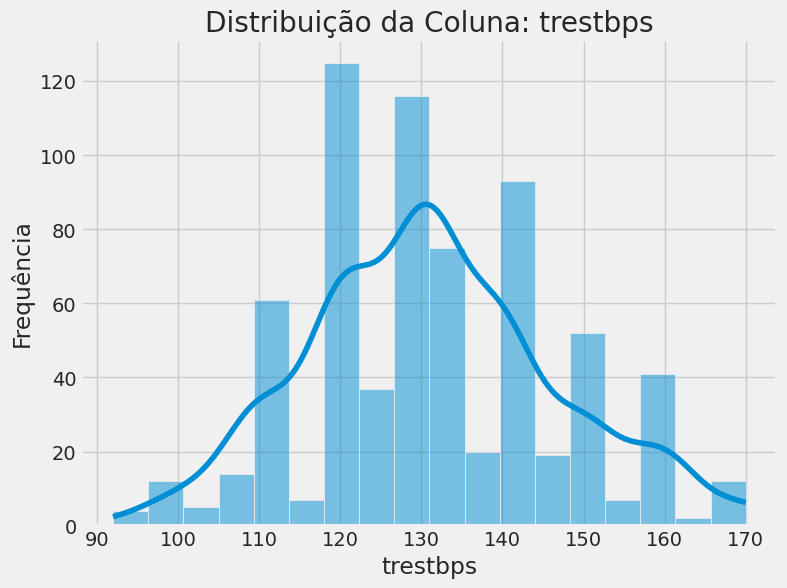

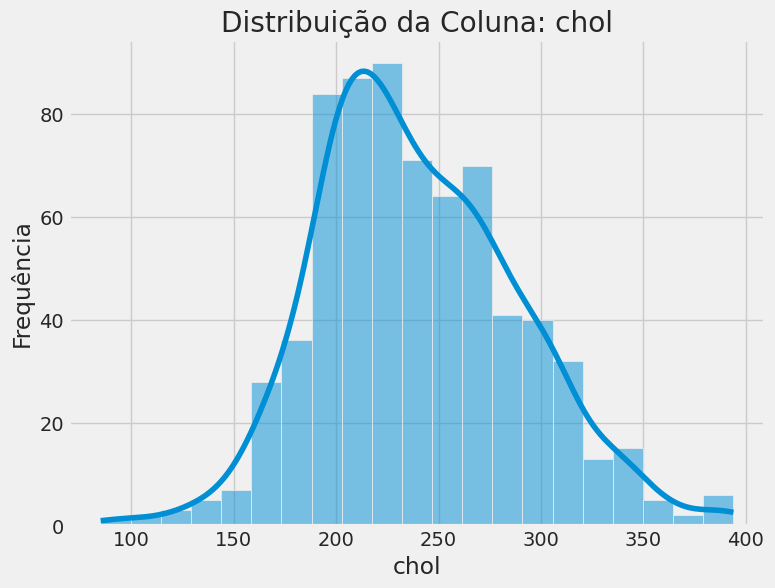

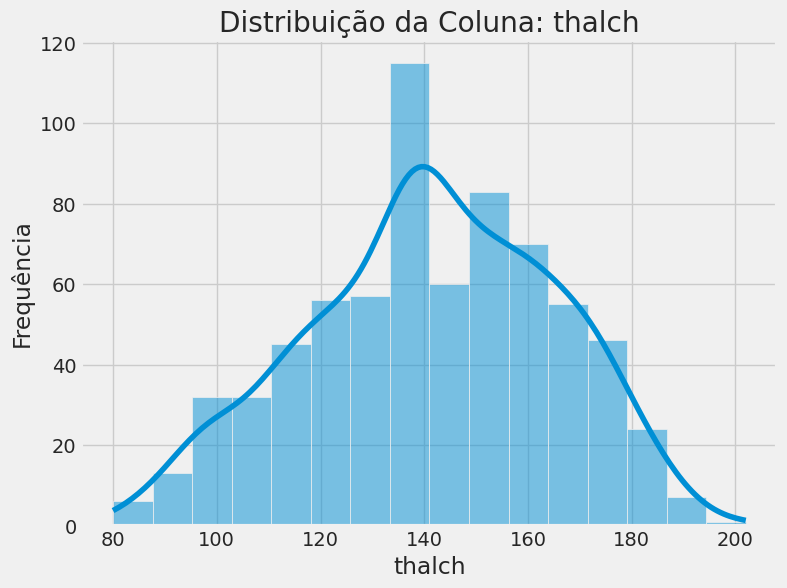

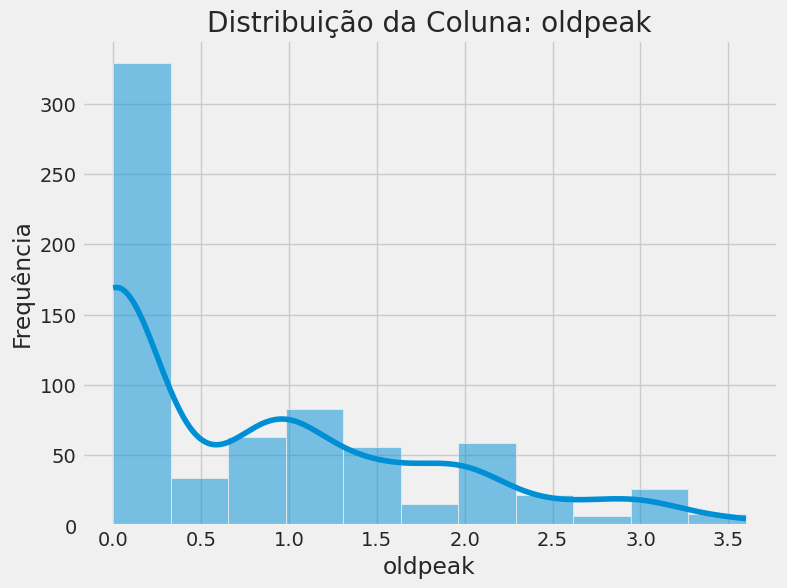

In [ ]:
# --- FUNÇÃO PARA PLOTAR HISTOGRAMA ---
def plot_histogram(df, column_name):
    """Plota um histograma para a coluna especificada."""
    plt.figure(figsize=(8, 6))
    sns.histplot(df[column_name], kde=True)
    plt.title(f'Distribuição da Coluna: {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequência')
    plt.show()

# Exemplo de uso da função para plotar a distribuição da idade
plot_histogram(df_dataset, 'age')
plot_histogram(df_dataset, 'trestbps')
plot_histogram(df_dataset, 'chol')
plot_histogram(df_dataset, 'thalch')
plot_histogram(df_dataset, 'oldpeak')

3. Prepação para Predição

In [ ]:
# Define o "grid" com as combinações de hiperparâmetros a serem testadas para o XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Cria o modelo XGBoost
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Configura o GridSearchCV para otimizar com base no F1-Score
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='f1')

# Treina o modelo com a busca de hiperparâmetros
grid_search.fit(X_train, y_train)

# Exibe os melhores parâmetros encontrados
print("Melhores parâmetros encontrados para o XGBoost:")
print(grid_search.best_params_)

# Utiliza o melhor modelo para fazer previsões no conjunto de teste
best_xgb_model = grid_search.best_estimator_
y_pred_tuned_xgb = best_xgb_model.predict(X_test)

# Calcula e exibe a acurácia final e o relatório de classificação
final_accuracy_xgb = accuracy_score(y_test, y_pred_tuned_xgb)
print(f"\nAcurácia do modelo XGBoost otimizado no conjunto de teste: {final_accuracy_xgb:.4f}")

print("\n--- RELATÓRIO DE CLASSIFICAÇÃO COMPLETO ---")
print(classification_report(y_test, y_pred_tuned_xgb))

Melhores parâmetros encontrados para o XGBoost:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

Acurácia do modelo XGBoost otimizado no conjunto de teste: 0.8227

--- RELATÓRIO DE CLASSIFICAÇÃO COMPLETO ---
              precision    recall  f1-score   support

           0       0.81      0.86      0.83        72
           1       0.84      0.78      0.81        69

    accuracy                           0.82       141
   macro avg       0.82      0.82      0.82       141
weighted avg       0.82      0.82      0.82       141



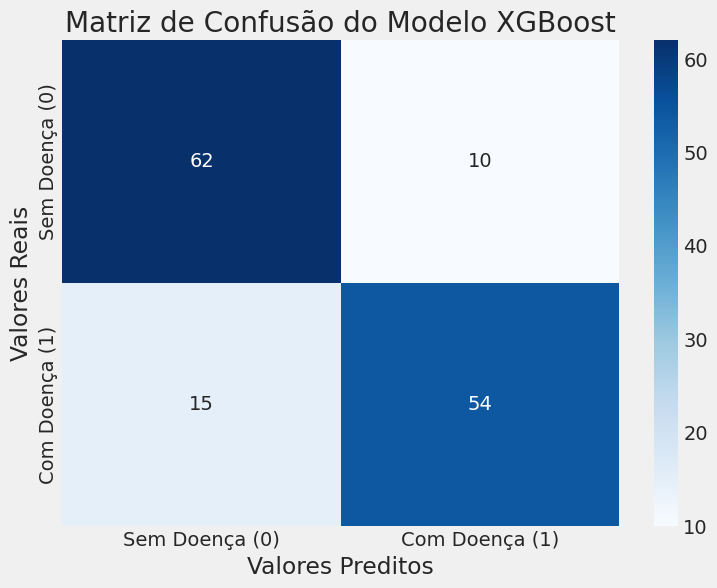

In [ ]:
# --- FUNÇÃO PARA PLOTAR MATRIZ DE CONFUSÃO ---
def plot_confusion_matrix(y_true, y_pred, title='Matriz de Confusão'):
    """Plota a matriz de confusão em um formato de heatmap."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sem Doença (0)', 'Com Doença (1)'], yticklabels=['Sem Doença (0)', 'Com Doença (1)'])
    plt.title(title)
    plt.ylabel('Valores Reais')
    plt.xlabel('Valores Preditos')
    plt.show()

# Exemplo de uso da função para plotar a matriz de confusão
plot_confusion_matrix(y_test, y_pred_tuned_xgb, title='Matriz de Confusão do Modelo XGBoost')

In [ ]:
import pandas as pd
import numpy as np

def prever_doenca_cardiaca(modelo, dados_paciente):
    """
    Realiza uma predição sobre a presença de doença cardíaca com base nos dados de um paciente.

    Args:
        modelo: O modelo XGBoost treinado (best_xgb_model).
        dados_paciente: Dicionário contendo os dados do paciente.

    Returns:
        Uma string com o resultado da predição.
    """
    # 1. Cria um DataFrame a partir do dicionário de dados do paciente
    df_paciente = pd.DataFrame([dados_paciente])

    # 2. Converte as colunas categóricas para o formato de one-hot encoding
    # As colunas precisam ser exatamente as mesmas do dataset de treino
    df_paciente['num'] = 0 # Adiciona a coluna 'num' para a padronização
    df_paciente = pd.get_dummies(df_paciente, drop_first=True)

    # 3. Garante que as colunas do paciente são as mesmas usadas para treinar o modelo
    colunas_treino = modelo.feature_names_in_
    df_paciente = df_paciente.reindex(columns=colunas_treino, fill_value=0)

    # 4. Faz a predição
    predicao = modelo.predict(df_paciente)

    # 5. Retorna o resultado em um formato fácil de ler
    if predicao[0] == 1:
        return "Previsão: Doença cardíaca detectada."
    else:
        return "Previsão: Sem doença cardíaca detectada."

# Exemplo de dados de um novo paciente
novo_paciente = {
    'age': 55,
    'sex': 'Male',
    'cp': 'non-anginal',
    'trestbps': 130,
    'chol': 250,
    'fbs': 'TRUE',
    'restecg': 'normal',
    'thalch': 170,
    'exang': 'FALSE',
    'oldpeak': 1.5,
    'slope': 'upsloping'
}

# Realiza a predição
resultado = prever_doenca_cardiaca(best_xgb_model, novo_paciente)
print(resultado)

Previsão: Sem doença cardíaca detectada.


In [ ]:
# --- FUNÇÃO PARA PREDICAÇÃO EM NOVOS DADOS ---
# A função é a mesma que já foi criada, então basta definí-la novamente
# para garantir que ela esteja na memória, caso você tenha limpado o ambiente.
import pandas as pd
import numpy as np

def prever_doenca_cardiaca(modelo, dados_paciente):
    """
    Realiza uma predição sobre a presença de doença cardíaca com base nos dados de um paciente.

    Args:
        modelo: O modelo XGBoost treinado (best_xgb_model).
        dados_paciente: Dicionário contendo os dados do paciente.

    Returns:
        Uma string com o resultado da predição.
    """
    df_paciente = pd.DataFrame([dados_paciente])

    # Preenche valores nulos com a média, se houver
    df_paciente.fillna(df_dataset.mean(numeric_only=True), inplace=True)

    # Remove colunas que não existiam no dataset de treino
    df_paciente.drop(['id', 'dataset'], axis=1, inplace=True, errors='ignore')

    # Converte colunas categóricas para o formato one-hot encoding
    df_paciente = pd.get_dummies(df_paciente, drop_first=True)

    # Garante que as colunas do paciente são as mesmas do treino
    colunas_treino = modelo.feature_names_in_
    df_paciente = df_paciente.reindex(columns=colunas_treino, fill_value=0)

    # Faz a predição
    predicao = modelo.predict(df_paciente)

    if predicao[0] == 1:
        return "Previsão: Doença cardíaca detectada."
    else:
        return "Previsão: Sem doença cardíaca detectada."

# Exemplo de dados de um novo paciente com maior risco
novo_paciente_risco = {
    'age': 65,
    'sex': 'Male',
    'cp': 'asymptomatic',
    'trestbps': 160,
    'chol': 300,
    'fbs': 'TRUE',
    'restecg': 'lv hypertrophy',
    'thalch': 120,
    'exang': 'TRUE',
    'oldpeak': 3.0,
    'slope': 'downsloping'
}

# Realiza a predição com os dados do paciente de maior risco
resultado = prever_doenca_cardiaca(best_xgb_model, novo_paciente_risco)
print(resultado)

Previsão: Doença cardíaca detectada.
